<a href="https://colab.research.google.com/github/SumantaSethi/Customer-Churn-Prediction-/blob/master/Modelling_Notebooks/DT_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:

import os
import pandas as pd
import numpy as np
import joblib

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

# Function for creating model pipelines - sklearn
from sklearn.pipeline import make_pipeline

# Import classifier
from sklearn import tree

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
from imblearn.over_sampling import SMOTE

In [27]:
abt = pd.read_csv("https://raw.githubusercontent.com/SumantaSethi/Customer-Churn-Prediction-/master/Resources/Analytical_Base_Table.csv")
abt.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Model Training

Splitting dataframe into separate objects:

x for the input features

y for the target variable

In [28]:
# Object for target variable
y = abt.Exited

# object for input features
X = abt.drop(['Exited'], axis=1)

# display shapes of X and y
print(X.shape, y.shape)

(10000, 10) (10000,)


In [29]:
# List numerical features
num_columns = X.select_dtypes(include='number').columns.tolist()
num_columns

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [30]:
# List categorical features
cat_columns = X.select_dtypes(include='object').columns.tolist()
cat_columns

['Geography', 'Gender']

In [31]:
def class_count(a):
    counter=Counter(a)
    kv=[list(counter.keys()),list(counter.values())]
    abt2 = pd.DataFrame(np.array(kv).T, columns=['Exited','Count'])
    abt2['Count'] = abt2['Count'].astype('int64')
    abt2['%'] = round(abt2['Count'] / a.shape[0] * 100, 2)
    return abt2.sort_values('Count',ascending=False)

In [32]:
class_count(y)

,Exited,Count,%
1,0,7963,79.63
0,1,2037,20.37


# Split the data

Splitting our data into separate training and test sets

training set(70%): to teach the model

testing set(30%): to evaluate performance

In [33]:
random_state = 10

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=random_state,
                                                    stratify=abt.Exited)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

7000 3000 7000 3000


In [34]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 8061 to 4741
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      7000 non-null   int64  
 1   Geography        7000 non-null   object 
 2   Gender           7000 non-null   object 
 3   Age              7000 non-null   int64  
 4   Tenure           7000 non-null   int64  
 5   Balance          7000 non-null   float64
 6   NumOfProducts    7000 non-null   int64  
 7   HasCrCard        7000 non-null   int64  
 8   IsActiveMember   7000 non-null   int64  
 9   EstimatedSalary  7000 non-null   float64
dtypes: float64(2), int64(6), object(2)
memory usage: 601.6+ KB


/tmp/ipython-input-2059830282.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Exited', y='Count', data=exited_distribution, palette='viridis')


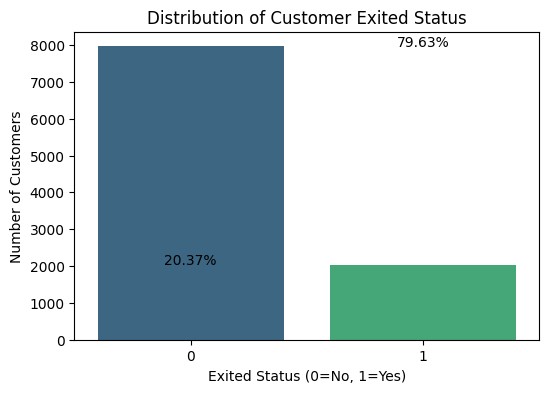

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

exited_distribution = class_count(y)

plt.figure(figsize=(6, 4))
sns.barplot(x='Exited', y='Count', data=exited_distribution, palette='viridis')
plt.title('Distribution of Customer Exited Status')
plt.xlabel('Exited Status (0=No, 1=Yes)')
plt.ylabel('Number of Customers')

# Add percentage labels on top of the bars
for index, row in exited_distribution.iterrows():
    plt.text(index, row['Count'], f"{row['%']}%", color='black', ha="center")

plt.show()

/tmp/ipython-input-2123055447.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Geography', data=X_train, palette='viridis')


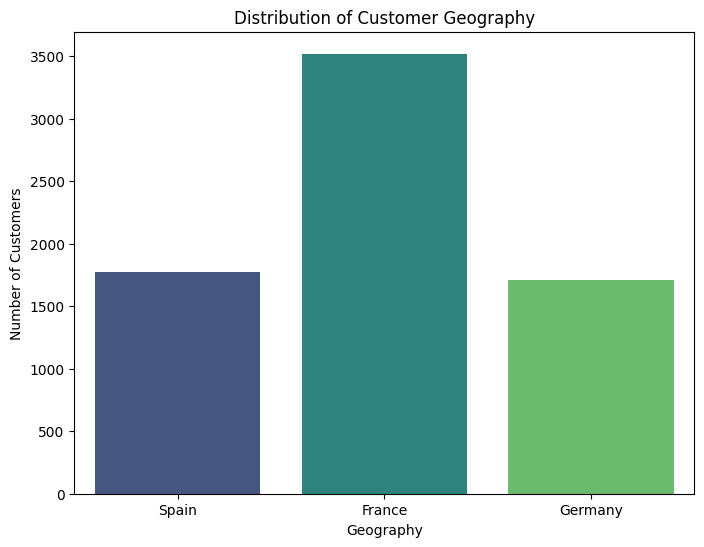

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='Geography', data=X_train, palette='viridis')
plt.title('Distribution of Customer Geography')
plt.xlabel('Geography')
plt.ylabel('Number of Customers')
plt.show()

# Preprocessing pipeline

Scale numerical data and encode categorical data

MinMaxScaler and OneHotEncoder Create lists of indexes from the list of column namesNeed to be numeric not string to specify columns name in column transformer

In [38]:
num_features = []

for i in num_columns:
    location = X.columns.get_loc(i)
    num_features.append(location)
print(num_features)

[0, 3, 4, 5, 6, 7, 8, 9]


In [39]:
cat_features = []

for i in cat_columns:
    location = X.columns.get_loc(i)
    cat_features.append(location)
print(cat_features)

[1, 2]


In [43]:
# Define column transformer
# Need to be numeric not string to specify columns name
preprocess = make_column_transformer(
    (MinMaxScaler(), num_features),
        (OneHotEncoder(sparse_output=False), cat_features)
        )
preprocess

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 [0, 3, 4, 5, 6, 7, 8, 9]),
                                ('onehotencoder',
                                 OneHotEncoder(sparse_output=False), [1, 2])])

In [45]:
# Import classifier
from sklearn import tree

# Define model with pipeline
model = imbl_pipe(preprocess,
                  SMOTE(sampling_strategy='auto', random_state=random_state),
                  tree.DecisionTreeClassifier(random_state=random_state))

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [0, 3, 4, 5, 6, 7, 8, 9]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  [1, 2])])),
                ('smote', SMOTE(random_state=10)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=10))])

In [48]:
# Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
dt_param_grid = {
    'decisiontreeclassifier__max_leaf_nodes': [2, 10, 20, 30],
    'decisiontreeclassifier__min_samples_split': [2, 3, 4],
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

dt_grid = GridSearchCV(model, dt_param_grid, verbose=3, cv= 5, scoring='accuracy')

In [49]:
X_train = X_train.values
X_test = X_test.values

In [50]:
dt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_leaf_nodes=2, decisiontreeclassifier__min_samples_split=2;, score=0.714 total time=   0.1s
[CV 2/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_leaf_nodes=2, decisiontreeclassifier__min_samples_split=2;, score=0.685 total time=   0.2s
[CV 3/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_leaf_nodes=2, decisiontreeclassifier__min_samples_split=2;, score=0.680 total time=   0.2s
[CV 4/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_leaf_nodes=2, decisiontreeclassifier__min_samples_split=2;, score=0.714 total time=   0.2s
[CV 5/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_leaf_nodes=2, decisiontreeclassifier__min_samples_split=2;, score=0.744 total time=   0.1s
[CV 1/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__m

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8,
                                                                          9]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse_output=False),
                                                                         [1,
                                                                          2])])),
                                       ('smote', SMOTE(random_state=10)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=10))]),
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_leaf_nodes': [2, 10, 20,
                                                                    30],
                         'decisiontreeclassifier__min_samples_split': [2, 3,
                                                                       4]},
             scoring='accuracy', verbose=3)

In [51]:
print(dt_grid.best_params_)

{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_leaf_nodes': 30, 'decisiontreeclassifier__min_samples_split': 2}


In [52]:
print(dt_grid.best_score_)

0.8130000000000001


In [53]:
print(f"Training Data Score: {dt_grid.score(X_train, y_train)}")
print(f"Testing Data Score: {dt_grid.score(X_test, y_test)}")

Training Data Score: 0.805
Testing Data Score: 0.7973333333333333


In [54]:
predictions = dt_grid.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   [0 0 0 0 0 1 0 0 0 1]
First 10 Actual labels: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [55]:
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)

,Prediction,Actual
0,0,1
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2995,1,0
2996,0,0
2997,1,0
2998,0,0


In [56]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[1979  410]
 [ 198  413]]


In [57]:
cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
print(cm)

[[0.83 0.17]
 [0.32 0.68]]


In [58]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87      2389
           1       0.50      0.68      0.58       611

    accuracy                           0.80      3000
   macro avg       0.71      0.75      0.72      3000
weighted avg       0.83      0.80      0.81      3000



In [59]:
pred = dt_grid.predict(X_test[:1])

In [60]:
print(f"Predicted classes: {pred}")
print(f"Actual Labels: {list(y_test[:1])}")

Predicted classes: [0]
Actual Labels: [1]


In [66]:
import joblib

filename ='Nate_DT.sav'
joblib.dump(dt_grid, filename)

['Nate_DT.sav']

In [67]:
dt_model = joblib.load(filename)
print(dt_model.score(X_test, y_test))

0.7973333333333333
